In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My\ Drive

/content/gdrive/My Drive


In [3]:
# Install necessary packages -> uncomment what is currently needed

!pip install unidecode
!pip install contractions
!pip install wordsegment
!pip install -U symspellpy
!pip install emoji --upgrade
!pip install -U imbalanced-learn
!pip install bert-for-tf2
!pip install transformers
# !pip install nltk

Requirement already up-to-date: symspellpy in /usr/local/lib/python3.6/dist-packages (6.5.2)
Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.6.2)


In [4]:
# All imports - DO NOT CHANGE THE ORDER OF INSTRUCTIONS
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo

import re
import os
import sys
import json

if not 'bert_repo' in sys.path:
    sys.path.insert(0, 'bert_repo')

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import spacy
from bs4 import BeautifulSoup
import unidecode
import contractions
import gensim.downloader as api
import re
import wordsegment
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import emoji
from imblearn.over_sampling import SMOTE
import tensorflow as tf2
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from modeling import BertModel, BertConfig
from tokenization import FullTokenizer, convert_to_unicode
from extract_features import InputExample, convert_examples_to_features
from tqdm import tqdm
#import tensorflow_addons as tfa
# import nltk
from google.colab import auth, drive
# nltk.download('punkt')

wordsegment.load()

# Load SymSpell -> package for correcting misspellings
sym_spell = SymSpell(2, 7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# get TF logger 
log = logging.getLogger('tensorflow')
log.handlers = []

Using TensorFlow backend.


In [102]:
'''
#Import data
training_examples_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/SemEval-2020-Task12/master/data2019/olid-training-v1.0.tsv'
testing_examples_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levela.tsv'
testing_labels_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levela.csv'
testing_examples_C_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levelc.tsv'
testing_labels_C_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levelc.csv'

training_dataset = pd.read_csv(training_examples_url, delimiter='\t')
testing_dataset_examples_A = pd.read_csv(testing_examples_A_url, delimiter='\t')
testing_dataset_labels_A = pd.read_csv(testing_labels_A_url, delimiter=',')
testing_dataset_examples_C = pd.read_csv(testing_examples_A_url, delimiter='\t')
testing_dataset_labels_C = pd.read_csv(testing_labels_A_url, delimiter=',')

print(training_dataset.head())
'''

      id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]


## Additional datasets

In [103]:
'''
#Import 2020 data

training_dataset2020_A = pd.read_csv('Colab Notebooks/task_a_distant.tsv', delimiter='\t', nrows=500000)
training_dataset2020_C = pd.read_csv('Colab Notebooks/task_c_distant_ann.tsv', delimiter='\t')
training_dataset2020_C
'''

,id,text,average_ind,average_grp,average_oth,std_ind,std_grp,std_oth
0,1159533712079503361,@USER Trump is a fucking idiot his dementia is...,0.833432,0.076110,0.107765,0.208334,0.098937,0.138649
1,1159533713044234241,@USER HELL YES! His grinned and thumbs up are ...,0.481062,0.367363,0.138841,0.345225,0.335924,0.083230
2,1159533718345830400,@USER Can't wait to see the shit show his deat...,0.438813,0.268574,0.377573,0.182609,0.186880,0.254621
3,1159533739871002625,@USER @USER @USER This guys is dumb check his ...,0.712995,0.123504,0.111130,0.248839,0.107572,0.067552
4,1159533742366633984,@USER @USER Fuck him better than his hoes,0.691414,0.146723,0.192282,0.204415,0.154818,0.104436
...,...,...,...,...,...,...,...,...
188968,1187532615030587394,"If you lying bout lil shit, you lying bout a l...",0.690031,0.178021,0.201831,0.249506,0.189998,0.166256
188969,1187611970624610304,do y’all ever like wanna grab somebodys face a...,0.503566,0.316713,0.260821,0.302630,0.146222,0.220385
188970,1187636295306268673,I meant tool but the point is women ain’t shit...,0.363758,0.431517,0.282849,0.239436,0.165351,0.095065
188971,1187636299785744384,@USER i sang too the fuck-,0.598230,0.161560,0.251305,0.191871,0.107075,0.115206


In [104]:
'''
c_dict = ['IND', 'GRP', 'OTH']

def convert_averages(row):
    return 'OFF' if row['average'] >= 0.4 else 'NOT'

def convert_averages_c(row):
    averages = [row['average_ind'], row['average_grp'], row['average_oth']]
    stds = [row['std_ind'], row['std_grp'], row['std_oth']]
    max_avg_id = np.argmax(averages)
    for i in range(3):
        if i == max_avg_id:
            continue

        return c_dict[i] if max(0, averages[i] - stds[i]) - 0.3 > max(0, averages[max_avg_id] - stds[max_avg_id]) else c_dict[max_avg_id]


training_dataset2020_A = training_dataset2020_A.drop(labels=['id', 'std'], axis=1)
training_dataset2020_A['average'] = training_dataset2020_A.apply(lambda row: convert_averages(row), axis=1)
training_dataset2020_A = training_dataset2020_A.rename(columns={ 'average': 'subtask_a', 'text': 'tweet' })

training_offensive_A = training_dataset2020_A[training_dataset2020_A['subtask_a'] == 'OFF'].head(50000)
training_neutral_A = training_dataset2020_A[training_dataset2020_A['subtask_a'] == 'NOT'].head(50000)

training_dataset2020_C['subtask_c'] = training_dataset2020_C.apply(lambda row: convert_averages_c(row), axis=1)
training_dataset2020_C = training_dataset2020_C.drop(labels=['id', 'average_ind', 'average_grp', 'average_oth', 'std_ind', 'std_grp', 'std_oth'], axis=1)

training_individual_C = training_dataset2020_C[training_dataset2020_C['subtask_c'] == 'IND'].head(63500)
training_non_individual_C = training_dataset2020_C[training_dataset2020_C['subtask_c'] != 'IND']

training_dataset = training_dataset.append(training_offensive_A)
training_dataset = training_dataset.append(training_neutral_A)
# training_dataset = training_dataset.append(training_dataset2020_C)
training_dataset = training_dataset.append(training_individual_C)
training_dataset = training_dataset.append(training_non_individual_C)
training_dataset = training_dataset.sample(frac=1, random_state=13)
training_dataset
'''

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,id,subtask_a,subtask_b,subtask_c,text,tweet
173034,NaN,OFF,NaN,NaN,NaN,@USER @USER That's awful news!😢
54655,NaN,NOT,NaN,NaN,NaN,@USER Likewise. Feel free to contact me whenev...
30512,NaN,OFF,NaN,NaN,NaN,I f*ckd up a whole chipotle burrito in 5 minut...
130082,NaN,OFF,NaN,NaN,NaN,its not even been a singluar day and my shenan...
42319,NaN,NaN,NaN,IND,i’m such a terrible texter but i swear ion be ...,NaN
...,...,...,...,...,...,...
67528,NaN,NaN,NaN,IND,Idgaf if it’s 2019 no one better ask me to eat...,NaN
51437,NaN,OFF,NaN,NaN,NaN,"GOD DAMN IT, I MADE THE COVER BUT IT SOUNDS LI..."
3169,NaN,NOT,NaN,NaN,NaN,"In a sky full of stars, I think I saw you. -..."
63663,NaN,NaN,NaN,IND,Mcinnes blaming the referee fuck me your squad...,NaN


In [105]:
'''
# Additional datasets
set_urls = [
            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set1.csv',
            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set2.csv',
            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set3.csv',
            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set4.csv',
            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set5.csv',
]
sets = [pd.read_csv(url) for url in set_urls]
'''

"\n# Additional datasets\nset_urls = [\n            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set1.csv',\n            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set2.csv',\n            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set3.csv',\n            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set4.csv',\n            'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/Additional%20datasets/set5.csv',\n]\nsets = [pd.read_csv(url) for url in set_urls]\n"

In [106]:
'''
def labels_set1(row):
  return 'OFF' if 1 in [row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']] else 'NOT'

def labels_set2(row):
  return 'OFF' if row['class'] != 2 else 'NOT'

def labels_set_ordinary(row):
  return 'OFF' if row['subtask_a'] == 1 else 'NOT'
'''

"\ndef labels_set1(row):\n  return 'OFF' if 1 in [row['toxic'], row['severe_toxic'], row['obscene'], row['threat'], row['insult'], row['identity_hate']] else 'NOT'\n\ndef labels_set2(row):\n  return 'OFF' if row['class'] != 2 else 'NOT'\n\ndef labels_set_ordinary(row):\n  return 'OFF' if row['subtask_a'] == 1 else 'NOT'\n"

In [107]:
'''
# Preprocess additional datasets

sets[0] = sets[0].rename(columns={ 'label': 'subtask_a' })
sets[0]['subtask_a'] = sets[0].apply(lambda row: labels_set_ordinary(row), axis=1)
sets[0] = sets[0].drop('id', axis=1)

sets[1] = sets[1].rename(columns={ 'comment_text': 'tweet', 'label': 'subtask_a' })
sets[1]['subtask_a'] = sets[1].apply(lambda row: labels_set1(row), axis=1)
sets[1] = sets[1].drop(labels=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)

sets[2] = sets[2].rename(columns={ 'label': 'subtask_a' })
sets[2]['subtask_a'] = sets[2].apply(lambda row: labels_set2(row), axis=1)
sets[2] = sets[2].drop(labels=['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'Unnamed: 0'], axis=1)

sets[3] = sets[3].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
sets[3]['subtask_a'] = sets[3].apply(lambda row: labels_set_ordinary(row), axis=1)
sets[3] = sets[3].drop('Date', axis=1)

sets[4] = sets[4].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
sets[4]['subtask_a'] = sets[4].apply(lambda row: labels_set_ordinary(row), axis=1)
sets[4] = sets[4].drop(labels=['Date', 'Usage'], axis=1)

sets[5] = sets[5].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })
sets[5]['subtask_a'] = sets[5].apply(lambda row: labels_set_ordinary(row), axis=1)
sets[5] = sets[5].drop(labels=['Date', 'id', 'Usage'], axis=1)

sets_hate_only = [s[s['subtask_a'] == 'OFF'] for s in sets]

for s in sets: # one can change to sets_hate_only
  training_dataset = training_dataset.append(s)

sets_hate_only
'''

"\n# Preprocess additional datasets\n\nsets[0] = sets[0].rename(columns={ 'label': 'subtask_a' })\nsets[0]['subtask_a'] = sets[0].apply(lambda row: labels_set_ordinary(row), axis=1)\nsets[0] = sets[0].drop('id', axis=1)\n\nsets[1] = sets[1].rename(columns={ 'comment_text': 'tweet', 'label': 'subtask_a' })\nsets[1]['subtask_a'] = sets[1].apply(lambda row: labels_set1(row), axis=1)\nsets[1] = sets[1].drop(labels=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)\n\nsets[2] = sets[2].rename(columns={ 'label': 'subtask_a' })\nsets[2]['subtask_a'] = sets[2].apply(lambda row: labels_set2(row), axis=1)\nsets[2] = sets[2].drop(labels=['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'Unnamed: 0'], axis=1)\n\nsets[3] = sets[3].rename(columns={ 'Insult': 'subtask_a', 'Comment': 'tweet' })\nsets[3]['subtask_a'] = sets[3].apply(lambda row: labels_set_ordinary(row), axis=1)\nsets[3] = sets[3].drop('Date', axis=1)\n\nsets[4] = sets[4].rename(col

# **Training and validation sets**

In [0]:
'''
seed = 13
c_mapping = {'IND': 0, 'GRP': 1, 'OTH': 2}

# prepare training examples
training_examples_A = training_dataset['tweet'][training_dataset['subtask_a'].notnull()]
training_examples_B = training_dataset['tweet'][training_dataset['subtask_b'].notnull()]
training_examples_C = training_dataset['tweet'][training_dataset['subtask_c'].notnull()]

# prepare training labels
training_labels_A = (training_dataset['subtask_a'][training_dataset['subtask_a'].notnull()] == 'OFF').astype(int)
training_labels_B = (training_dataset['subtask_b'][training_dataset['subtask_b'].notnull()] == 'TIN').astype(int)
training_labels_C = training_dataset['subtask_c'][training_dataset['subtask_c'].notnull()].replace(c_mapping)

# split training set into training and validation
training_examples_A, validation_examples_A, training_labels_A, validation_labels_A = train_test_split(
    training_examples_A, training_labels_A, test_size=0.1, stratify=training_labels_A, random_state=seed)
training_examples_B, validation_examples_B, training_labels_B, validation_labels_B = train_test_split(
    training_examples_B, training_labels_B, test_size=0.1, stratify=training_labels_B, random_state=seed)
training_examples_C, validation_examples_C, training_labels_C, validation_labels_C = train_test_split(
    training_examples_C, training_labels_C, test_size=0.1, stratify=training_labels_C, random_state=seed)


# prepare test examples and labels
test_examples_A = testing_dataset_examples_A['tweet'][testing_dataset_examples_A['tweet'].notnull()]
test_labels_A = (testing_dataset_labels_A['label'][testing_dataset_labels_A['label'].notnull()] == 'OFF').astype(int)

test_examples_C = testing_dataset_examples_C['tweet'][testing_dataset_examples_C['tweet'].notnull()]
test_labels_C = testing_dataset_labels_C['label'][testing_dataset_labels_C['label'].notnull()].replace(c_mapping)

training_x = np.array(training_examples_A)
validation_x = np.array(validation_examples_A)
training_y = np.array(training_labels_A)
validation_y = np.array(validation_labels_A)
test_x = np.array(test_examples_A)
test_y = np.array(test_labels_A)


training_x_c = np.array(training_examples_C)
validation_x_c = np.array(validation_examples_C)
training_y_c = np.array(training_labels_C)
validation_y_c = np.array(validation_labels_C)
test_x_c = np.array(test_examples_C)
test_y_c = np.array(test_labels_C)
'''

In [114]:
training_x = np.array(pd.read_csv('training_examples_A.csv'))
validation_x = np.array(pd.read_csv('validation_examples_A.csv'))
training_y = np.array(pd.read_csv('training_labels_A.csv'))
validation_y = np.array(pd.read_csv('validation_labels_A.csv'))

training_x_c = np.array(pd.read_csv('training_examples_C_limited.csv'))
validation_x_c = np.array(pd.read_csv('validation_examples_C_limited.csv'))
training_y_c = np.array(pd.read_csv('training_labels_C_limited.csv'))
validation_y_c = np.array(pd.read_csv('validation_labels_C_limited.csv'))

testing_examples_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levela.tsv'
testing_labels_A_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levela.csv'
testing_examples_C_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/testset-levelc.tsv'
testing_labels_C_url = 'https://raw.githubusercontent.com/piotrjaniszewski1/Offensive-Language-Identification-and-Categorization/master/data2019/labels-levelc.csv'

testing_dataset_examples_A = np.array(pd.read_csv(testing_examples_A_url, delimiter='\t'))
testing_dataset_labels_A = np.array(pd.read_csv(testing_labels_A_url, delimiter=','))
testing_dataset_examples_C = np.array(pd.read_csv(testing_examples_A_url, delimiter='\t'))
testing_dataset_labels_C = np.array(pd.read_csv(testing_labels_A_url, delimiter=','))

training_x

array([['@USER Us conservatives hope he does.'],
       ['Lowkey want to have breakfast for dinner tonight 🤔'],
       ['@USER So black people need white liberals like you to keep them from turning to violence based on things they perceive to be offensive?'],
       ...,
       ['Rahm Emanuel’s failure is an ill omen for all Democrats"  URL #TCOT #MAGA #RedNationRising"'],
       ['@USER you are right and you should say it'],
       ["Is it over? 'cause I'm blowin' out the flame"]], dtype=object)

In [110]:
# save randomized datasets to files
'''
training_examples_A.to_csv('training_examples_A.csv', index=False, index_label=False)
validation_examples_A.to_csv('validation_examples_A.csv', index=False, index_label=False)
training_labels_A.to_csv('training_labels_A.csv', index=False, index_label=False)
validation_labels_A.to_csv('validation_labels_A.csv', index=False, index_label=False)


training_examples_C.to_csv('training_examples_C_limited.csv', index=False, index_label=False)
validation_examples_C.to_csv('validation_examples_C_limited.csv', index=False, index_label=False)
training_labels_C.to_csv('training_labels_C_limited.csv', index=False, index_label=False)
validation_labels_C.to_csv('validation_labels_C_limited.csv', index=False, index_label=False)
'''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11:

# **Preprocessing**

### Common preprocessing functions

In [0]:
# remove html tags if exist
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=' ')
    return stripped_text


# remove unnecessary whitespaces
def remove_whitespace(text):
    text = text.strip()
    return ' '.join(text.split())


# remove accented chars (e.g. caffè -> caffe)
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text


# remove hashes and split words (e.g. '#fortTrump' -> 'fort trump')
def split_hashtags(text):
    splitted = text.split()
    new_word_sequence = []

    for chunk in splitted:
        if chunk[0] == '#':
            chunk = chunk[1:]
            new_word_sequence.extend(wordsegment.segment(chunk))
        else:
            new_word_sequence.append(chunk)
        
    return ' '.join(tuple(new_word_sequence))


def substitute_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.compile('[_:]+').sub(' ', demojized_text)


def preprocess_common(text):
    text = strip_html_tags(text)
    text = contractions.fix(text)
    text = split_hashtags(text)
    text = substitute_emojis(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    return text.lower()

In [0]:
# Remove redundant @user tokens
def remove_redundant_users(example):
    user_count = 0
    new_example = example[:]
    for i, token in reversed(list(enumerate(example))):
        if token == '@user':
            user_count += 1
        if user_count > 3:
            new_example.pop(i)
    else:
        user_count = 0

    return new_example

### Spacy preprocessing

In [0]:
# Try leaving '?' and '!' as far as punctuation is concerned

nlp = spacy.load('en_core_web_sm')

# exclude negation words from spacy stopwords list
deselect_stop_words = ['no', 'not', 'noone', 'none', 'lacks', 'lack', 'nor', 'never', 'neighter', 'hardly', 'nobody', 'nothing', 'lacking', 'nowhere']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def preprocess_spacy(text):
    doc = nlp(text)

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        '''
        # remove punctuations
        if token.pos_ == 'PUNCT' and flag == True and token.text != '@user': 
            flag = False
       
        # remove special characters
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
        
        # remove numbers
        if (token.pos_ == 'NUM' or token.text.isnumeric()) and flag == True:
            flag = False

        # correct misspelings
        # if flag == True:
            # suggestions = sym_spell.lookup(edit, Verbosity.TOP, 2)
            # if len(suggestions) > 0:
                # edit = suggestions[0].term

        # remove stop words
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert tokens to base form
        elif token.lemma_ != '-PRON-' and flag == True:
            edit = token.lemma_
        '''
        # append tokens edited and not removed to list 
        if edit != '' and flag == True:
            clean_text.append(edit)        
    
    return clean_text

### Preprocessing execution

In [0]:
cleaned_x = [preprocess_spacy(example) for example in training_x[0:30]]
reduced_users_x = [remove_redundant_users(example) for example in cleaned_x]
print(reduced_users_x[0:30])
print(training_x[0:30])

# **BERT**

### BERT Preprocessing - single example


In [0]:
def preprocess_bert_before_tokenization(text):
    preprocessed_text = preprocess_common(text)
    spacy_x = preprocess_spacy(text)
    cleaned_x = remove_redundant_users(spacy_x)
    return ' '.join(cleaned_x)

### Getting the pre-trained model

In [0]:
!wget https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
!unzip wwm_uncased_L-24_H-1024_A-16.zip

--2020-03-04 21:35:21--  https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1248381879 (1.2G) [application/zip]
Saving to: ‘wwm_uncased_L-24_H-1024_A-16.zip.3’

wwm_uncased_L-24_H- 100%[===================>]   1.16G  35.1MB/s    in 34s     

2020-03-04 21:35:55 (34.9 MB/s) - ‘wwm_uncased_L-24_H-1024_A-16.zip.3’ saved [1248381879/1248381879]

Archive:  wwm_uncased_L-24_H-1024_A-16.zip
replace wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt.meta  
  inflating: wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt.data-00000-of-00001  A

  inflating: wwm_uncased_L-24_H-1024_A-16/vocab.txt  
  inflating: wwm_uncased

### Building a tf.Module

In [0]:
def build_module_fn(config_path, vocab_path, do_lower_case=True):

    def bert_module_fn(is_training):
        """Spec function for a token embedding module."""

        input_ids = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_ids")
        input_mask = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_mask")
        token_type = tf.placeholder(shape=[None, None], dtype=tf.int32, name="segment_ids")

        config = BertConfig.from_json_file(config_path)
        model = BertModel(config=config, is_training=is_training,
                          input_ids=input_ids, input_mask=input_mask, token_type_ids=token_type)
          
        seq_output = model.all_encoder_layers[-1]
        pool_output = model.get_pooled_output()

        config_file = tf.constant(value=config_path, dtype=tf.string, name="config_file")
        vocab_file = tf.constant(value=vocab_path, dtype=tf.string, name="vocab_file")
        lower_case = tf.constant(do_lower_case)

        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, config_file)
        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, vocab_file)
            
        input_map = {"input_ids": input_ids,
                     "input_mask": input_mask,
                     "segment_ids": token_type}
        
        output_map = {"pooled_output": pool_output,
                      "sequence_output": seq_output}

        output_info_map = {"vocab_file": vocab_file,
                           "do_lower_case": lower_case}
                
        hub.add_signature(name="tokens", inputs=input_map, outputs=output_map)
        hub.add_signature(name="tokenization_info", inputs={}, outputs=output_info_map)

    return bert_module_fn

### Exporting the module

In [0]:
MODEL_DIR = "wwm_uncased_L-24_H-1024_A-16"

config_path = "/content/gdrive/My Drive/{}/bert_config.json".format(MODEL_DIR)
vocab_path = "/content/gdrive/My Drive/{}/vocab.txt".format(MODEL_DIR)

tags_and_args = []
for is_training in (True, False):
  tags = set()
  if is_training:
    tags.add("train")
  tags_and_args.append((tags, dict(is_training=is_training)))

module_fn = build_module_fn(config_path, vocab_path)
spec = hub.create_module_spec(module_fn, tags_and_args=tags_and_args)
spec.export("bert-module", 
            checkpoint_path="/content/gdrive/My Drive/{}/bert_model.ckpt".format(MODEL_DIR))


### Building the text preprocessing pipeline

In [0]:
def read_examples(str_list):
    """Read a list of `InputExample`s from a list of strings."""
    unique_id = 0
    for s in str_list:
        line = convert_to_unicode(s)
        if not line:
            continue
        
        text_a = line.strip()
        splitted = re.split(r'[.?!]\s*', text_a)
        text_b = splitted[-1]
        text_a.replace(text_b, '')


        yield InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b)
        unique_id += 1

In [0]:
def features_to_arrays(features):

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.input_type_ids)

    return (np.array(all_input_ids, dtype='int32'), 
            np.array(all_input_mask, dtype='int32'), 
            np.array(all_segment_ids, dtype='int32'))

In [0]:
def build_preprocessor(voc_path, seq_len, lower=True):
    tokenizer = FullTokenizer(vocab_file=voc_path, do_lower_case=lower)

    def strings_to_arrays(sents):

        sents = np.atleast_1d(sents).reshape((-1,))

        examples = []
        for example in read_examples(sents):
            example.text_a = preprocess_bert_before_tokenization(example.text_a)
            examples.append(example)

        features = convert_examples_to_features(examples, seq_len, tokenizer)
        arrays = features_to_arrays(features)
        
        return arrays

    return strings_to_arrays

### Implementing a BERT Keras layer

In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_path, seq_len=64, n_tune_layers=3, 
                 pooling="cls", do_preprocessing=True, verbose=False,
                 tune_embeddings=False, trainable=True, **kwargs):

        self.trainable = trainable
        self.n_tune_layers = n_tune_layers
        self.tune_embeddings = tune_embeddings
        self.do_preprocessing = do_preprocessing

        self.verbose = verbose
        self.seq_len = seq_len
        self.pooling = pooling
        self.bert_path = bert_path

        self.var_per_encoder = 16
        if self.pooling not in ["cls", "mean", "lstm", None]:
            raise NameError(
                f"Undefined pooling type (must be either 'cls', 'mean', or None, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.bert = hub.Module(self.build_abspath(self.bert_path), 
                               trainable=self.trainable, name=f"{self.name}_module")

        trainable_layers = []
        if self.tune_embeddings:
            trainable_layers.append("embeddings")

        if self.pooling == "cls":
            trainable_layers.append("pooler")

        if self.n_tune_layers > 0:
            encoder_var_names = [var.name for var in self.bert.variables if 'encoder' in var.name]
            n_encoder_layers = int(len(encoder_var_names) / self.var_per_encoder)
            for i in range(self.n_tune_layers):
                trainable_layers.append(f"encoder/layer_{str(n_encoder_layers - 1 - i)}/")
        
        # Add module variables to layer's trainable weights
        for var in self.bert.variables:
            if any([l in var.name for l in trainable_layers]):
                self._trainable_weights.append(var)
            else:
                self._non_trainable_weights.append(var)

        if self.verbose:
            print("*** TRAINABLE VARS *** ")
            for var in self._trainable_weights:
                print(var)

        self.build_preprocessor()
        self.initialize_module()

        super(BertLayer, self).build(input_shape)

    def build_abspath(self, path):
        if path.startswith("https://") or path.startswith("gs://"):
          return path
        else:
          return os.path.abspath(path)

    def build_preprocessor(self):
        sess = tf.keras.backend.get_session()
        tokenization_info = self.bert(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        self.preprocessor = build_preprocessor(vocab_file, self.seq_len, do_lower_case)

    def initialize_module(self):
        sess = tf.keras.backend.get_session()
        
        vars_initialized = sess.run([tf.is_variable_initialized(var) 
                                     for var in self.bert.variables])

        uninitialized = []
        for var, is_initialized in zip(self.bert.variables, vars_initialized):
            if not is_initialized:
                uninitialized.append(var)

        if len(uninitialized):
            sess.run(tf.variables_initializer(uninitialized))

    def call(self, input):
        if self.do_preprocessing:
          input = tf.numpy_function(self.preprocessor, 
                                    [input], [tf.int32, tf.int32, tf.int32], 
                                    name='preprocessor')
          for feature in input:
            feature.set_shape((None, self.seq_len))
        
        input_ids, input_mask, segment_ids = input
        
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        output = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)

        if self.pooling == "cls":
            pooled = output["pooled_output"]
        else:
            result = output["sequence_output"]

            if self.pooling == "lstm":
              lstm = tf.keras.layers.LSTM(1)
              pooled = lstm(result)

            else:
              input_mask = tf.cast(input_mask, tf.float32)
              mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
              masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                      tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
              
              if self.pooling == "mean":
                pooled = masked_reduce_mean(result, input_mask)
              else:
                pooled = mul_mask(result, input_mask)

        return pooled

    def get_config(self):
        config_dict = {
            "bert_path": self.bert_path, 
            "seq_len": self.seq_len,
            "pooling": self.pooling,
            "n_tune_layers": self.n_tune_layers,
            "tune_embeddings": self.tune_embeddings,
            "do_preprocessing": self.do_preprocessing,
            "verbose": self.verbose
        }
        super(BertLayer, self).get_config()
        return config_dict

### Classification

In [0]:
inp = tf.keras.Input(shape=(1,), dtype=tf.string)
encoder = BertLayer(bert_path="./bert-module/", seq_len=200, tune_embeddings=False,
                    pooling='cls', n_tune_layers=24, verbose=False)

l1 = tf.keras.layers.Dense(768, activation='relu')
l2 = tf.keras.layers.Dense(768, activation='relu')
# l3 = tf.keras.layers.Dense(1024, activation='relu')
d = tf.keras.layers.Dropout(0.5)

pred = tf.keras.layers.Dense(1, activation='sigmoid')(d(l2(l1(encoder(inp)))))

model = tf.keras.models.Model(inputs=[inp], outputs=[pred])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall + tf.keras.backend.epsilon()))

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(training_y),
                                            training_y)
class_weights /= max(class_weights)

# print(class_weights) # [majority class weight, minority class weight]

minority_count = len(training_labels_A[training_labels_A == 1])
majority_count = len(training_labels_A[training_labels_A == 0])

def weighted_loss(actual, predicted):
    weights = class_weights
    # weights = [0.0714, 1.0]
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce(actual, predicted)
   
    return tf.keras.backend.mean(loss * weights)

In [0]:
model.summary()

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6, ),
      loss=weighted_loss,
      metrics=[f1_m])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
bert_layer_2 (BertLayer)     (None, 1024)              335141888 
_________________________________________________________________
dense_6 (Dense)              (None, 768)               787200    
_________________________________________________________________
dense_7 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 769       
Total params: 336,520,449
Trainable params: 304,737,537
Non-trainable params: 31,782,912
______________________________________

### Training

In [0]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [0]:
saver = keras.callbacks.ModelCheckpoint("bert_large_H8_S256_B32.hdf5")

history = model.fit(training_x, training_y, validation_data=[validation_x, validation_y], batch_size=16, epochs=1, callbacks=[saver])

Train on 11916 samples, validate on 1324 samples


### Loss function graph

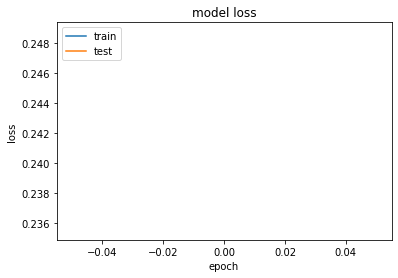

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predict

In [0]:
predicted = model.predict(test_x, batch_size=16)

### Count f1-score

In [0]:
from sklearn.metrics import f1_score

def round_int(array, threshold):
  return np.array([np.ceil(x) if x >= threshold else np.floor(x) for x in array]).astype(np.float64)

flat_predicted = round_int(predicted[:, 0], 0.4)
print(f1_score(test_y, flat_predicted))

0.7208791208791209


In [0]:
testing_dataset_examples_A = pd.read_csv('Colab Notebooks/test_a_tweets.tsv', delimiter='\t')
test_examples_A = np.array(testing_dataset_examples_A['tweet'][testing_dataset_examples_A['tweet'].notnull()])
test_examples_A

array(['¿Who the fuck is Yoru?',
       "@USER @USER He's an evil law breaker that should be in prison with his criminal heartless family.",
       'Now hiring for 49 #Labor job opportunities in #Minnesota. Click the link in our bio to see them.',
       ...,
       '@USER @USER @USER @USER @USER Q for CSIA would both be functional OR only NMIA 🤔',
       '@USER Her parents should be in jail for child-abuse  Jesus Christ, poor kid brainwashed',
       '@USER @USER @USER @USER @USER Trump is a trash criminal president.'],
      dtype=object)

In [0]:
model_emb = tf.keras.models.Model(inputs=[model.layers[0].input], outputs=[model.layers[-3].output])

In [0]:
data = model_emb.predict(test_examples_A)

In [0]:
np.savez('2020-TEST-bert-embeddings.npz', data)

## Saving and restoring

In [0]:
import json
json.dump(model.to_json(), open("bert_H4_S256_B64.json", "w"))

In [0]:
model = tf.keras.models.model_from_json(json.load(open("bert_H4_S256_B64.json")), 
                                        custom_objects={"BertLayer": BertLayer})

model.load_weights("bert_H4_S256_B64.hdf5")

FileNotFoundError: ignored

In [0]:
model.predict(training_x[:10])

### Freeze model

In [0]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference

def freeze_keras_model(model, export_path=None, clear_devices=True):
    """
    Freezes a Keras model into a pruned computation graph.

    @param model The Keras model to be freezed.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    
    sess = tf.keras.backend.get_session()
    graph = sess.graph
    
    with graph.as_default():

        input_tensors = model.inputs
        output_tensors = model.outputs
        dtypes = [t.dtype.as_datatype_enum for t in input_tensors]
        input_ops = [t.name.rsplit(":", maxsplit=1)[0] for t in input_tensors]
        output_ops = [t.name.rsplit(":", maxsplit=1)[0] for t in output_tensors]
        
        tmp_g = graph.as_graph_def()
        if clear_devices:
            for node in tmp_g.node:
                node.device = ""
        
        tmp_g = optimize_for_inference(
            tmp_g, input_ops, output_ops, dtypes, False)
        
        tmp_g = convert_variables_to_constants(sess, tmp_g, output_ops)
        
        if export_path is not None:
            with tf.gfile.GFile(export_path, "wb") as f:
                f.write(tmp_g.SerializeToString())
        
        return tmp_g

In [0]:
frozen_graph = freeze_keras_model(model, export_path="frozen_graph_4_256_64.pb")

In [0]:
!git clone https://github.com/gaphex/bert_experimental/

import tensorflow as tf
import numpy as np
import sys

sys.path.insert(0, "/content/bert_experimental")

from bert_experimental.finetuning.text_preprocessing import build_preprocessor
from bert_experimental.finetuning.graph_ops import load_graph

In [0]:
restored_graph = load_graph("frozen_graph_4_256_64.pb")

In [0]:
graph_ops = restored_graph.get_operations()
input_op, output_op = graph_ops[0].name, graph_ops[-1].name
print(input_op, output_op)

In [0]:
x = restored_graph.get_tensor_by_name(input_op + ':0')
y = restored_graph.get_tensor_by_name(output_op + ':0')

In [0]:
preprocessor = build_preprocessor("./uncased_L-12_H-768_A-12/vocab.txt", 64)
py_func = tf.numpy_function(preprocessor, [x], [tf.int32, tf.int32, tf.int32], name='preprocessor')

In [0]:
py_func = tf.numpy_function(preprocessor, [x], [tf.int32, tf.int32, tf.int32])

In [0]:
sess = tf.Session(graph=restored_graph)

In [0]:
y_out = sess.run(y, feed_dict={
        x: training_x[:10].reshape((-1,1))
    })

y_out